# Hypothetical Document Embedding (HyDE) for RAG

In this notebook, I implement HyDE (Hypothetical Document Embedding) - an innovative retrieval technique that transforms user queries into hypothetical answer documents before performing retrieval. This approach bridges the semantic gap between short queries and lengthy documents.

Traditional RAG systems embed the user's short query directly, but this often fails to capture the semantic richness needed for optimal retrieval. HyDE solves this by:

- Generating a hypothetical document that answers the query
- Embedding this expanded document instead of the original query
- Retrieving documents similar to this hypothetical document
- Creating more contextually relevant answers

## Setting Up the Environment
We begin by importing necessary libraries.

In [1]:
import os
import numpy as np
import json
import fitz
import re
import matplotlib.pyplot as plt
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

True

In [2]:
embedding_deployment = "text-embedding-ada-002"
chat_deployment = "gpt-4o"

## Setting Up the OpenAI API Client
We initialize the OpenAI client to generate embeddings and responses.

In [3]:
# Initialize the Azure OpenAI client with the endpoint and API key
from openai import AzureOpenAI

endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_version = os.getenv("API_VERSION")

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=os.getenv("AZURE_OPENAI_API_KEY")
)

## Document Processing Functions

In [4]:
def extract_text_from_pdf(pdf_path):
    """
    Extract text content from a PDF file with page separation.
    
    Args:
        pdf_path (str): Path to the PDF file
        
    Returns:
        List[Dict]: List of pages with text content and metadata
    """
    print(f"Extracting text from {pdf_path}...")  # Print the path of the PDF being processed
    pdf = fitz.open(pdf_path)  # Open the PDF file using PyMuPDF
    pages = []  # Initialize an empty list to store the pages with text content
    
    # Iterate over each page in the PDF
    for page_num in range(len(pdf)):
        page = pdf[page_num]  # Get the current page
        text = page.get_text()  # Extract text from the current page
        
        # Skip pages with very little text (less than 50 characters)
        if len(text.strip()) > 50:
            # Append the page text and metadata to the list
            pages.append({
                "text": text,
                "metadata": {
                    "source": pdf_path,  # Source file path
                    "page": page_num + 1  # Page number (1-based index)
                }
            })
    
    print(f"Extracted {len(pages)} pages with content")  # Print the number of pages extracted
    return pages  # Return the list of pages with text content and metadata

In [5]:
def chunk_text(text, chunk_size=1000, overlap=200):
    """
    Split text into overlapping chunks.
    
    Args:
        text (str): Input text to chunk
        chunk_size (int): Size of each chunk in characters
        overlap (int): Overlap between chunks in characters
        
    Returns:
        List[Dict]: List of chunks with metadata
    """
    chunks = []  # Initialize an empty list to store the chunks
    
    # Iterate over the text in steps of (chunk_size - overlap)
    for i in range(0, len(text), chunk_size - overlap):
        chunk_text = text[i:i + chunk_size]  # Extract the chunk of text
        if chunk_text:  # Ensure we don't add empty chunks
            chunks.append({
                "text": chunk_text,  # Add the chunk text
                "metadata": {
                    "start_pos": i,  # Start position of the chunk in the original text
                    "end_pos": i + len(chunk_text)  # End position of the chunk in the original text
                }
            })
    
    print(f"Created {len(chunks)} text chunks")  # Print the number of chunks created
    return chunks  # Return the list of chunks with metadata

## Simple Vector Store Implementation

In [6]:
class SimpleVectorStore:
    """
    A simple vector store implementation using NumPy.
    """
    def __init__(self):
        self.vectors = []  # List to store vector embeddings
        self.texts = []  # List to store text content
        self.metadata = []  # List to store metadata
    
    def add_item(self, text, embedding, metadata=None):
        """
        Add an item to the vector store.
        
        Args:
            text (str): Text content
            embedding (List[float]): Vector embedding
            metadata (Dict, optional): Additional metadata
        """
        self.vectors.append(np.array(embedding))  # Append the embedding as a numpy array
        self.texts.append(text)  # Append the text content
        self.metadata.append(metadata or {})  # Append the metadata or an empty dict if None
    
    def similarity_search(self, query_embedding, k=5, filter_func=None):
        """
        Find the most similar items to a query embedding.
        
        Args:
            query_embedding (List[float]): Query embedding vector
            k (int): Number of results to return
            filter_func (callable, optional): Function to filter results
            
        Returns:
            List[Dict]: Top k most similar items
        """
        if not self.vectors:
            return []  # Return an empty list if there are no vectors
        
        # Convert query embedding to numpy array
        query_vector = np.array(query_embedding)
        
        # Calculate similarities using cosine similarity
        similarities = []
        for i, vector in enumerate(self.vectors):
            # Skip if doesn't pass the filter
            if filter_func and not filter_func(self.metadata[i]):
                continue
                
            # Calculate cosine similarity
            similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
            similarities.append((i, similarity))  # Append index and similarity score
        
        # Sort by similarity (descending)
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        # Return top k results
        results = []
        for i in range(min(k, len(similarities))):
            idx, score = similarities[i]
            results.append({
                "text": self.texts[idx],  # Add the text content
                "metadata": self.metadata[idx],  # Add the metadata
                "similarity": float(score)  # Add the similarity score
            })
        
        return results  # Return the list of top k results

## Creating Embeddings

In [7]:
def create_embeddings(texts):
    """
    Create embeddings for the given texts using Azure OpenAI's embedding model.
    
    Args:
        texts (List[str]): Input texts
        
    Returns:
        List[List[float]]: Embedding vectors
    """
    # Handle empty input
    if not texts:
        return []
        
    # Process in batches if needed (Azure OpenAI API limits)
    batch_size = 100
    all_embeddings = []
    
    # Iterate over the input texts in batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # Get the current batch of texts
        
        # Create embeddings for the current batch
        response = client.embeddings.create(
            model=embedding_deployment,
            input=batch
        )
        
        # Extract embeddings from the response
        batch_embeddings = [item.embedding for item in response.data]
        all_embeddings.extend(batch_embeddings)  # Add the batch embeddings to the list
    
    return all_embeddings  # Return all embeddings

## Document Processing Pipeline

In [8]:
def process_document(pdf_path, chunk_size=1000, chunk_overlap=200):
    """
    Process a document for RAG.
    
    Args:
        pdf_path (str): Path to the PDF file
        chunk_size (int): Size of each chunk in characters
        chunk_overlap (int): Overlap between chunks in characters
        
    Returns:
        SimpleVectorStore: Vector store containing document chunks
    """
    # Extract text from the PDF file
    pages = extract_text_from_pdf(pdf_path)
    
    # Process each page and create chunks
    all_chunks = []
    for page in pages:
        # Pass the text content (string) to chunk_text, not the dictionary
        page_chunks = chunk_text(page["text"], chunk_size, chunk_overlap)
        
        # Update metadata for each chunk with the page's metadata
        for chunk in page_chunks:
            chunk["metadata"].update(page["metadata"])
        
        all_chunks.extend(page_chunks)
    
    # Create embeddings for the text chunks
    print("Creating embeddings for chunks...")
    chunk_texts = [chunk["text"] for chunk in all_chunks]
    chunk_embeddings = create_embeddings(chunk_texts)
    
    # Create a vector store to hold the chunks and their embeddings
    vector_store = SimpleVectorStore()
    for i, chunk in enumerate(all_chunks):
        vector_store.add_item(
            text=chunk["text"],
            embedding=chunk_embeddings[i],
            metadata=chunk["metadata"]
        )
    
    print(f"Vector store created with {len(all_chunks)} chunks")
    return vector_store

## Hypothetical Document Generation

In [9]:
def generate_hypothetical_document(query, desired_length=1000):
    """
    Generate a hypothetical document that answers the query.
    
    Args:
        query (str): User query
        desired_length (int): Target length of the hypothetical document
        
    Returns:
        str: Generated hypothetical document
    """
    # Define the system prompt to instruct the model on how to generate the document
    system_prompt = f"""You are an expert document creator. 
    Given a question, generate a detailed document that would directly answer this question.
    The document should be approximately {desired_length} characters long and provide an in-depth, 
    informative answer to the question. Write as if this document is from an authoritative source
    on the subject. Include specific details, facts, and explanations.
    Do not mention that this is a hypothetical document - just write the content directly."""

    # Define the user prompt with the query
    user_prompt = f"Question: {query}\n\nGenerate a document that fully answers this question:"
    
    # Make a request to the Azure OpenAI API to generate the hypothetical document
    response = client.chat.completions.create(
        model=chat_deployment,  # Specify the model to use
        messages=[
            {"role": "system", "content": system_prompt},  # System message to guide the assistant
            {"role": "user", "content": user_prompt}  # User message with the query
        ],
        temperature=0.1  # Set the temperature for response generation
    )
    
    # Return the generated document content
    return response.choices[0].message.content

## Complete HyDE RAG Implementation

In [10]:
def hyde_rag(query, vector_store, k=5, should_generate_response=True):
    """
    Perform RAG using Hypothetical Document Embedding.
    
    Args:
        query (str): User query
        vector_store (SimpleVectorStore): Vector store with document chunks
        k (int): Number of chunks to retrieve
        generate_response (bool): Whether to generate a final response
        
    Returns:
        Dict: Results including hypothetical document and retrieved chunks
    """
    print(f"\n=== Processing query with HyDE: {query} ===\n")
    
    # Step 1: Generate a hypothetical document that answers the query
    print("Generating hypothetical document...")
    hypothetical_doc = generate_hypothetical_document(query)
    print(f"Generated hypothetical document of {len(hypothetical_doc)} characters")
    
    # Step 2: Create embedding for the hypothetical document
    print("Creating embedding for hypothetical document...")
    hypothetical_embedding = create_embeddings([hypothetical_doc])[0]
    
    # Step 3: Retrieve similar chunks based on the hypothetical document
    print(f"Retrieving {k} most similar chunks...")
    retrieved_chunks = vector_store.similarity_search(hypothetical_embedding, k=k)
    
    # Prepare the results dictionary
    results = {
        "query": query,
        "hypothetical_document": hypothetical_doc,
        "retrieved_chunks": retrieved_chunks
    }
    
    # Step 4: Generate a response if requested
    if should_generate_response:
        print("Generating final response...")
        response = generate_response(query, retrieved_chunks)
        results["response"] = response
    
    return results

## Standard (Direct) RAG Implementation for Comparison

In [11]:
def standard_rag(query, vector_store, k=5, should_generate_response=True):
    """
    Perform standard RAG using direct query embedding.
    
    Args:
        query (str): User query
        vector_store (SimpleVectorStore): Vector store with document chunks
        k (int): Number of chunks to retrieve
        generate_response (bool): Whether to generate a final response
        
    Returns:
        Dict: Results including retrieved chunks
    """
    print(f"\n=== Processing query with Standard RAG: {query} ===\n")
    
    # Step 1: Create embedding for the query
    print("Creating embedding for query...")
    query_embedding = create_embeddings([query])[0]
    
    # Step 2: Retrieve similar chunks based on the query embedding
    print(f"Retrieving {k} most similar chunks...")
    retrieved_chunks = vector_store.similarity_search(query_embedding, k=k)
    
    # Prepare the results dictionary
    results = {
        "query": query,
        "retrieved_chunks": retrieved_chunks
    }
    
    # Step 3: Generate a response if requested
    if should_generate_response:
        print("Generating final response...")
        response = generate_response(query, retrieved_chunks)
        results["response"] = response
        
    return results

## Response Generation

In [12]:
def generate_response(query, relevant_chunks):
    """
    Generate a final response based on the query and relevant chunks.
    
    Args:
        query (str): User query
        relevant_chunks (List[Dict]): Retrieved relevant chunks
        
    Returns:
        str: Generated response
    """
    # Concatenate the text from the chunks to create context
    context = "\n\n".join([chunk["text"] for chunk in relevant_chunks])
    
    # Generate response using Azure OpenAI API
    response = client.chat.completions.create(
        model=chat_deployment,
        messages=[
            {"role": "system", "content": "You are a helpful assistant. Answer the question based on the provided context."},
            {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}"}
        ],
        temperature=0.5,
        max_tokens=500
    )
    
    return response.choices[0].message.content

## Evaluation Functions

In [13]:
def compare_approaches(query, vector_store, reference_answer=None):
    """
    Compare HyDE and standard RAG approaches for a query.
    
    Args:
        query (str): User query
        vector_store (SimpleVectorStore): Vector store with document chunks
        reference_answer (str, optional): Reference answer for evaluation
        
    Returns:
        Dict: Comparison results
    """
    # Run HyDE RAG
    hyde_result = hyde_rag(query, vector_store)
    hyde_response = hyde_result["response"]
    
    # Run standard RAG
    standard_result = standard_rag(query, vector_store)
    standard_response = standard_result["response"]
    
    # Compare results
    comparison = compare_responses(query, hyde_response, standard_response, reference_answer)
    
    return {
        "query": query,
        "hyde_response": hyde_response,
        "hyde_hypothetical_doc": hyde_result["hypothetical_document"],
        "standard_response": standard_response,
        "reference_answer": reference_answer,
        "comparison": comparison
    }

In [15]:

def compare_responses(query, hyde_response, standard_response, reference=None):
    """
    Compare responses from HyDE and standard RAG.
    
    Args:
        query (str): User query
        hyde_response (str): Response from HyDE RAG
        standard_response (str): Response from standard RAG
        reference (str, optional): Reference answer
        
    Returns:
        str: Comparison analysis
    """
    system_prompt = """You are an expert evaluator of information retrieval systems.
Compare the two responses to the same query, one generated using HyDE (Hypothetical Document Embedding) 
and the other using standard RAG with direct query embedding.

Evaluate them based on:
1. Accuracy: Which response provides more factually correct information?
2. Relevance: Which response better addresses the query?
3. Completeness: Which response provides more thorough coverage of the topic?
4. Clarity: Which response is better organized and easier to understand?

Be specific about the strengths and weaknesses of each approach."""

    user_prompt = f"""Query: {query}

Response from HyDE RAG:
{hyde_response}

Response from Standard RAG:
{standard_response}"""

    if reference:
        user_prompt += f"""

Reference Answer:
{reference}"""

    user_prompt += """

Please provide a detailed comparison of these two responses, highlighting which approach performed better and why."""

    response = client.chat.completions.create(
        model=chat_deployment,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0
    )
    
    return response.choices[0].message.content


In [16]:
def run_evaluation(pdf_path, test_queries, reference_answers=None, chunk_size=1000, chunk_overlap=200):
    """
    Run a complete evaluation with multiple test queries.
    
    Args:
        pdf_path (str): Path to the PDF document
        test_queries (List[str]): List of test queries
        reference_answers (List[str], optional): Reference answers for queries
        chunk_size (int): Size of each chunk in characters
        chunk_overlap (int): Overlap between chunks in characters
        
    Returns:
        Dict: Evaluation results
    """
    # Process document and create vector store
    vector_store = process_document(pdf_path, chunk_size, chunk_overlap)
    
    results = []
    
    for i, query in enumerate(test_queries):
        print(f"\n\n===== Evaluating Query {i+1}/{len(test_queries)} =====")
        print(f"Query: {query}")
        
        # Get reference answer if available
        reference = None
        if reference_answers and i < len(reference_answers):
            reference = reference_answers[i]
        
        # Compare approaches
        result = compare_approaches(query, vector_store, reference)
        results.append(result)
    
    # Generate overall analysis
    overall_analysis = generate_overall_analysis(results)
    
    return {
        "results": results,
        "overall_analysis": overall_analysis
    }

In [17]:
def generate_overall_analysis(results):
    """
    Generate an overall analysis of the evaluation results.
    
    Args:
        results (List[Dict]): Results from individual query evaluations
        
    Returns:
        str: Overall analysis
    """
    system_prompt = """You are an expert at evaluating information retrieval systems.
Based on multiple test queries, provide an overall analysis comparing HyDE RAG (using hypothetical document embedding)
with standard RAG (using direct query embedding).

Focus on:
1. When HyDE performs better and why
2. When standard RAG performs better and why
3. The types of queries that benefit most from HyDE
4. The overall strengths and weaknesses of each approach
5. Recommendations for when to use each approach"""

    # Create summary of evaluations
    evaluations_summary = ""
    for i, result in enumerate(results):
        evaluations_summary += f"Query {i+1}: {result['query']}\n"
        evaluations_summary += f"Comparison summary: {result['comparison'][:200]}...\n\n"

    user_prompt = f"""Based on the following evaluations comparing HyDE vs standard RAG across {len(results)} queries, 
provide an overall analysis of these two approaches:

{evaluations_summary}

Please provide a comprehensive analysis of the relative strengths and weaknesses of HyDE compared to standard RAG,
focusing on when and why one approach outperforms the other."""

    response = client.chat.completions.create(
        model=chat_deployment,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0
    )
    
    return response.choices[0].message.content

## Visualization Functions

In [18]:
def visualize_results(query, hyde_result, standard_result):
    """
    Visualize the results of HyDE and standard RAG approaches.
    
    Args:
        query (str): User query
        hyde_result (Dict): Results from HyDE RAG
        standard_result (Dict): Results from standard RAG
    """
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot the query in the first subplot
    axs[0].text(0.5, 0.5, f"Query:\n\n{query}", 
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, wrap=True)
    axs[0].axis('off')  # Hide the axis for the query plot
    
    # Plot the hypothetical document in the second subplot
    hypothetical_doc = hyde_result["hypothetical_document"]
    # Shorten the hypothetical document if it's too long
    shortened_doc = hypothetical_doc[:500] + "..." if len(hypothetical_doc) > 500 else hypothetical_doc
    axs[1].text(0.5, 0.5, f"Hypothetical Document:\n\n{shortened_doc}", 
                horizontalalignment='center', verticalalignment='center',
                fontsize=10, wrap=True)
    axs[1].axis('off')  # Hide the axis for the hypothetical document plot
    
    # Plot comparison of retrieved chunks in the third subplot
    # Shorten each chunk text for better visualization
    hyde_chunks = [chunk["text"][:100] + "..." for chunk in hyde_result["retrieved_chunks"]]
    std_chunks = [chunk["text"][:100] + "..." for chunk in standard_result["retrieved_chunks"]]
    
    # Prepare the comparison text
    comparison_text = "Retrieved by HyDE:\n\n"
    for i, chunk in enumerate(hyde_chunks):
        comparison_text += f"{i+1}. {chunk}\n\n"
    
    comparison_text += "\nRetrieved by Standard RAG:\n\n"
    for i, chunk in enumerate(std_chunks):
        comparison_text += f"{i+1}. {chunk}\n\n"
    
    # Plot the comparison text in the third subplot
    axs[2].text(0.5, 0.5, comparison_text, 
                horizontalalignment='center', verticalalignment='center',
                fontsize=8, wrap=True)
    axs[2].axis('off')  # Hide the axis for the comparison plot
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Display the plot
    plt.show()

## Evaluation of Hypothetical Document Embedding (HyDE) vs. Standard RAG

Extracting text from data/AI_Information.pdf...
Extracted 15 pages with content
Created 4 text chunks
Created 4 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 4 text chunks
Created 3 text chunks
Creating embeddings for chunks...
Vector store created with 48 chunks

=== Processing query with HyDE: What are the main ethical considerations in artificial intelligence development? ===

Generating hypothetical document...
Vector store created with 48 chunks

=== Processing query with HyDE: What are the main ethical considerations in artificial intelligence development? ===

Generating hypothetical document...
Generated hypothetical document of 3886 characters
Creating embedding for hypothetical document...
Retrieving 5 most similar chunks...
Generating final response...
Generated 

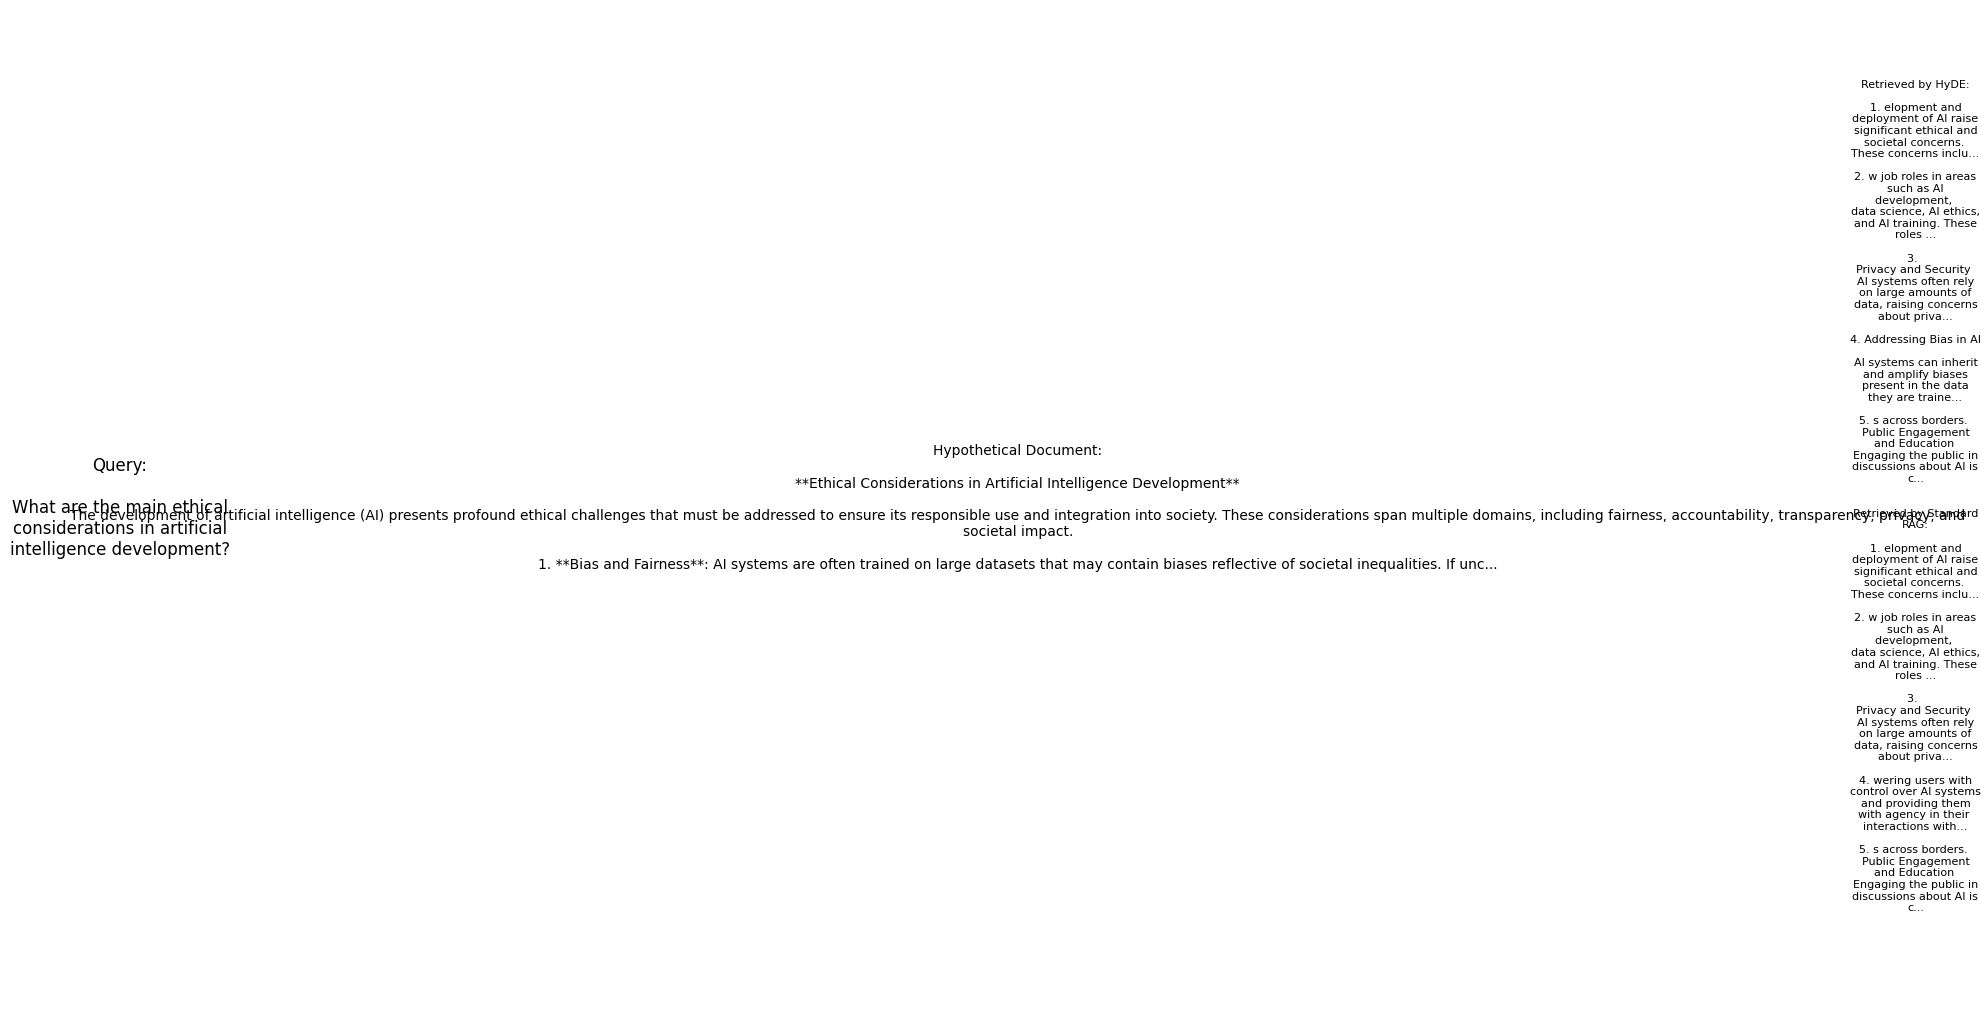

Extracting text from data/AI_Information.pdf...
Extracted 15 pages with content
Created 4 text chunks
Created 4 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 3 text chunks
Created 4 text chunks
Created 3 text chunks
Creating embeddings for chunks...
Vector store created with 48 chunks


===== Evaluating Query 1/1 =====
Query: How does neural network architecture impact AI performance?

=== Processing query with HyDE: How does neural network architecture impact AI performance? ===

Generating hypothetical document...
Vector store created with 48 chunks


===== Evaluating Query 1/1 =====
Query: How does neural network architecture impact AI performance?

=== Processing query with HyDE: How does neural network architecture impact AI performance? ===

Generating hypothetical document...
Generated hy

In [19]:
# Path to the AI information document
pdf_path = "data/AI_Information.pdf"

# Process document and create vector store
# This loads the document, extracts text, chunks it, and creates embeddings
vector_store = process_document(pdf_path)

# Example 1: Direct comparison for a single query related to AI
query = "What are the main ethical considerations in artificial intelligence development?"

# Run HyDE RAG approach
# This generates a hypothetical document answering the query, embeds it, 
# and uses that embedding to retrieve relevant chunks
hyde_result = hyde_rag(query, vector_store)
print("\n=== HyDE Response ===")
print(hyde_result["response"])

# Run standard RAG approach for comparison
# This directly embeds the query and uses it to retrieve relevant chunks
standard_result = standard_rag(query, vector_store)
print("\n=== Standard RAG Response ===")
print(standard_result["response"])

# Visualize the differences between HyDE and standard RAG approaches
# Shows the query, hypothetical document, and retrieved chunks side by side
visualize_results(query, hyde_result, standard_result)

# Example 2: Run full evaluation with multiple AI-related queries
test_queries = [
    "How does neural network architecture impact AI performance?"
]

# Optional reference answers for better evaluation
reference_answers = [
    "Neural network architecture significantly impacts AI performance through factors like depth (number of layers), width (neurons per layer), connectivity patterns, and activation functions. Different architectures like CNNs, RNNs, and Transformers are optimized for specific tasks such as image recognition, sequence processing, and natural language understanding respectively.",
]

# Run comprehensive evaluation comparing HyDE and standard RAG approaches
evaluation_results = run_evaluation(
    pdf_path=pdf_path,
    test_queries=test_queries,
    reference_answers=reference_answers
)

# Print the overall analysis of which approach performs better across queries
print("\n=== OVERALL ANALYSIS ===")
print(evaluation_results["overall_analysis"])